In [37]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os
import pandas as pd
import random
import scipy.linalg
import seaborn as sns
import time
from tqdm.notebook import tqdm
from scipy.sparse.linalg.eigen.arpack import eigsh as largest_eigsh
plt.ion()
%matplotlib inline
seed = 42
random.seed(seed) 
np.random.seed(seed)

class Timer(object):
    def __enter__(self):
        self.t0 = time.time()
    def __exit__(self, exc_type, exc_val, exc_tb):
        print('[time spent: {time:.2f}s]'.format(time = time.time() - self.t0))
        

path = 'result/reservoir jacob'
if not os.path.exists(path):
    os.makedirs(path)


(3, 20000)


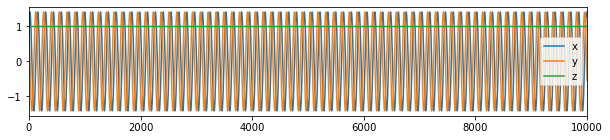

In [38]:

def trajectory(A, initial_point, num_points=1e4, h=1e-2):

    n = int(num_points)
    dim = len(initial_point)
    X = np.zeros([n, dim])

    X[0, :] = initial_point

    for k in range(1, n):
        X[k, :] = A@ X[k - 1, :] + (np.random.random(dim)-0.5)*0

    return X.T



N = 20000
step = 0.001
a = 0.999
b = np.sqrt(1-a**2)
A = np.array([[a,b,0],[-b,a,0],[0,0,1]])
# largest_eigvals, _ = largest_eigsh(A@A.T, 1, which='LM')
# rhoW = np.sqrt(largest_eigvals[0])
# A = A/rhoW

x = trajectory(A, [1,1,1], N, step)
plt.figure(figsize=(10,2))
plt.plot(x.T)
plt.legend(labels=['x','y','z'])
plt.xlim([0,10000])
print(x.shape)
U_linear = x


dataset shape: (1, 20000)


  0%|          | 0/20000 [00:00<?, ?it/s]

pre_output shape: (100, 10000)
W_out shape: (1, 100)


1.4934151999899813e-06

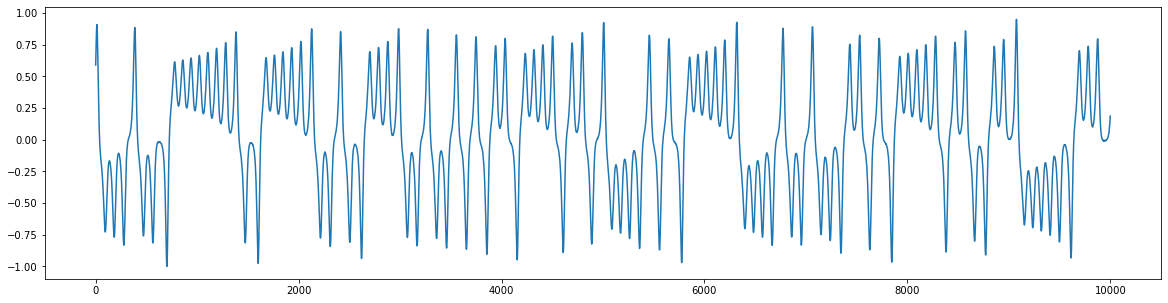

In [42]:
# system_name = 'Rossler'
# system_name = 'Rabinovich Fabrikant'
system_name = 'Lorenz'
# system_name ='Four-Scroll'

dim = [0]
U0 = np.loadtxt('dataset/matlab_gendata/'+system_name+'.csv', delimiter=',').T[dim]
# U0 = U_linear
U = U0 + np.random.randn(*U0.shape)*1e-3
U = np.atleast_2d(U)
num_prepare = 1000
train_start = num_prepare
num_train = 10000
val_start = num_prepare + num_train
num_val = 1000
test_start = num_prepare + num_train + num_val
num_test = 5000
print('dataset shape:', U.shape)


inSize = U.shape[0]
outSize = inSize  
resSize = 100
a = 1          # leaking rate
K = 1  # spectial redius
reg = 1e-6      # regularization coefficient 
input_scaling = 1


# generation of random weights
Win = (np.random.rand(resSize,inSize+1)-0.5) * input_scaling
W = np.random.rand(resSize,resSize)-0.5
largest_eigvals, _ = largest_eigsh(W@W.T, 1, which='LM')
rhoW = np.sqrt(largest_eigvals[0])
W = W/rhoW*K 
X = np.zeros((resSize,U.shape[1]))

x = np.zeros([resSize,1])

for t in tqdm(range(U.shape[1])):
    u = U[:,t:t+1]
    x = (1-a) * x + a * np.tanh( Win @ np.vstack((1,u)) + W @ x ) 
#     x = (1-a) * x + a * np.tanh( Win @ u + W @ x )
    X[:,t:t+1] = x

# X += np.random.randn(*X.shape)*1e-3
# offline train
U_train = U[:,train_start : train_start + num_train]
X_train = X[:,train_start : train_start + num_train]
Y_train = U0[:,train_start + 1 : train_start + num_train + 1]
# H = np.vstack((np.ones((1,X_train.shape[1])),X_train))
H = X_train


Wout = Y_train @ H.T @ np.linalg.inv( H @ H.T + reg*np.eye(H.shape[0]))
print('pre_output shape:', H.shape)
print('W_out shape:', Wout.shape)

plt.figure(figsize=(20,5))
plt.plot(U_train.T)

np.average(np.square(Y_train - Wout @ H))

In [66]:
X_train.shape, Y_train.shape

W1 = np.random.random((100, len(dim)+1))
Z = np.tanh(W1 @ np.vstack([np.ones((1,Y_train.shape[1])),Y_train]))
# Z = np.tanh(W1 @ Y_train)
W2 = X_train @ Z.T @ np.linalg.inv(Z @ Z.T + 1e-6*np.eye(Z.shape[0]))

W3 = X_train@ Y_train.T @ np.linalg.inv(Y_train @ Y_train.T + 1e-8*np.eye(Y_train.shape[0]))

SSE = np.sum(np.square(X_train - W2 @ Z))
SST = np.sum(np.square(X_train - np.average(X_train)))
R2_KR = 1- SSE/SST
print(SSE,R2_KR)

SSE = np.sum(np.square(X_train - W3 @ Y_train))
R2_LR = 1- SSE/SST
print(SSE,R2_LR)

48.93029016182672 0.999529122047258
87478.49299873784 0.15815554013741018


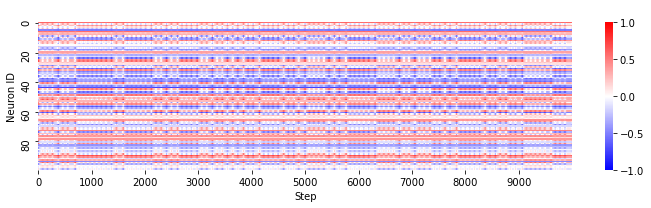

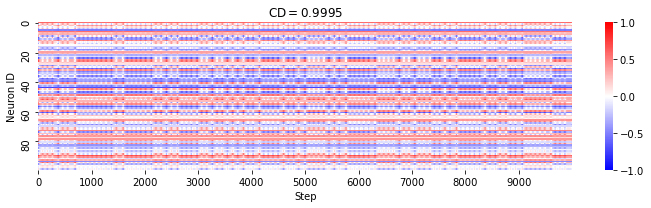

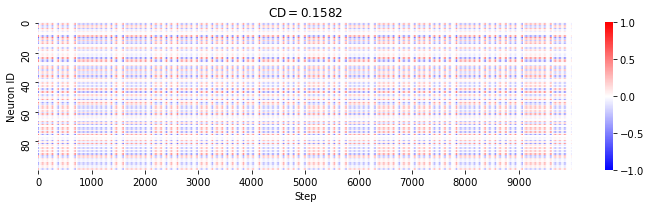

In [69]:
plt.figure(figsize=(10,3))
sns.heatmap(pd.DataFrame(X_train), yticklabels=20, xticklabels=1000, cmap='bwr',vmax=1,vmin=-1)
plt.xlabel('Step')
plt.ylabel('Neuron ID')
plt.title(' ')
plt.tight_layout()
plt.savefig(path+'/reservoir-state.png', transparent=True, dpi=300, pad_inches = 0)

plt.figure(figsize=(10,3))
sns.heatmap(W2 @ Z, yticklabels=20, xticklabels=1000, cmap='bwr',vmax=1,vmin=-1)
plt.xlabel('Step')
plt.ylabel('Neuron ID')
plt.title(r'CD$={:.4f}$'.format(R2_KR))
plt.tight_layout()
plt.savefig(path+'/recon-ELM.png', transparent=True, dpi=300, pad_inches = 0)

plt.figure(figsize=(10,3))
sns.heatmap(W3 @ Y_train, yticklabels=20, xticklabels=1000, cmap='bwr',vmax=1,vmin=-1)
plt.xlabel('Step')
plt.ylabel('Neuron ID')
plt.title(r'CD$={:.4f}$'.format(R2_LR))
plt.tight_layout()
plt.savefig(path+'/recon-LR.png', transparent=True, dpi=300, pad_inches = 0)
plt.show()

In [23]:
J = []
for i in tqdm(range(1,500)):
    dXdY = W2 @  np.diag(1 - np.square(Z[:,i-1])) @ W1
#     print(np.average(dXdY))
    jacob = Wout @ np.diag(1- np.square(X_train[:,i])) @ (W @ dXdY + Win)
    J.append(jacob)

J = np.array(J)


  0%|          | 0/499 [00:00<?, ?it/s]

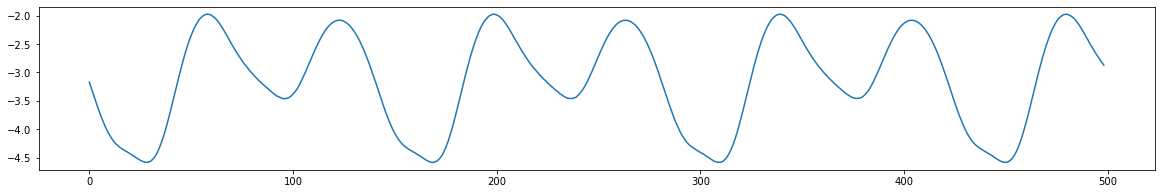

-3.150784437568159


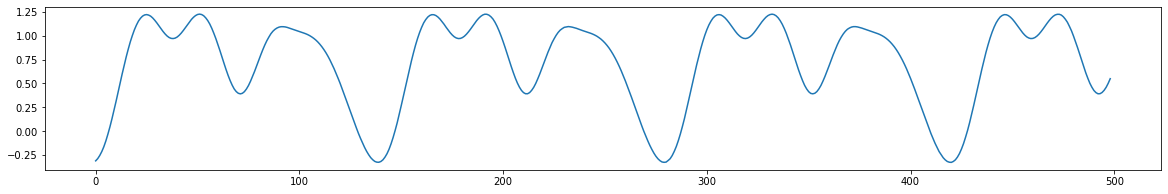

0.720646698317014


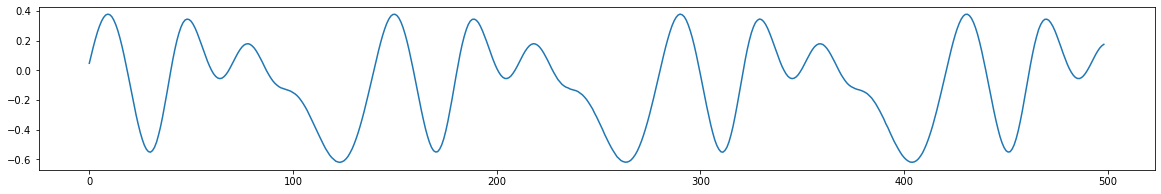

-0.07881446160819058


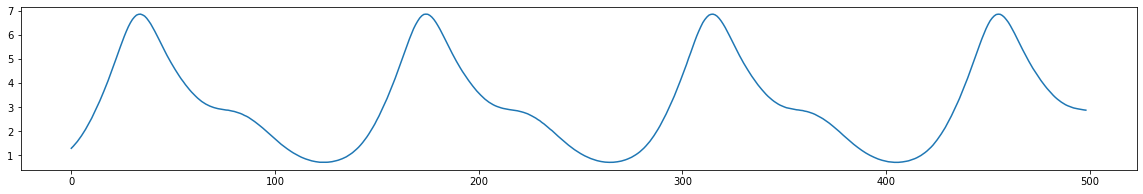

3.1705732915349354


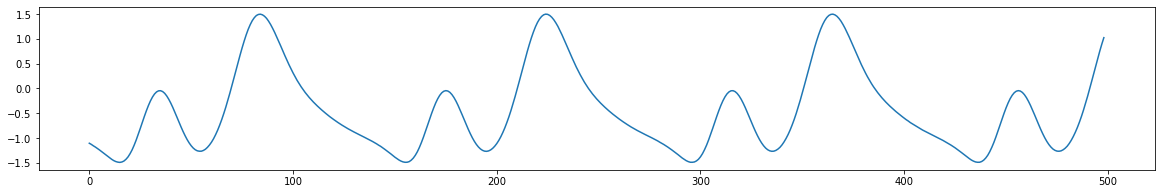

-0.44656442619910464


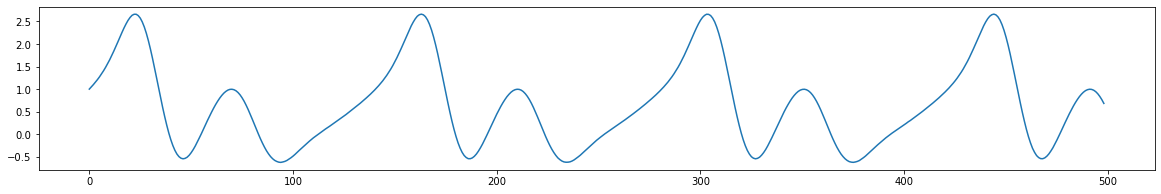

0.6473730201544062


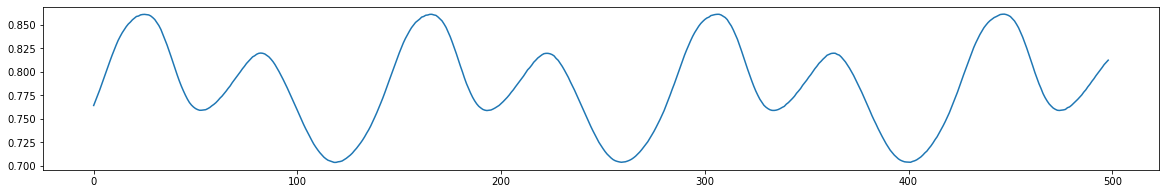

0.7855627430485577


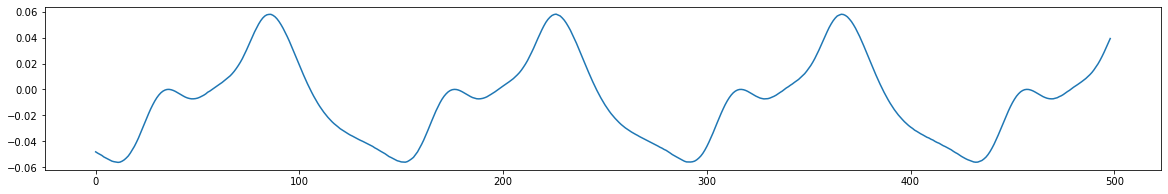

-0.008271216150951164


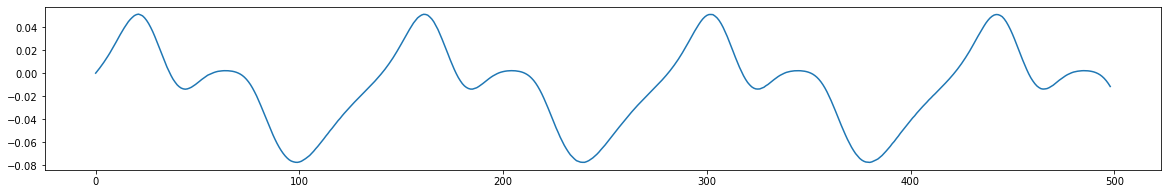

-0.010028668254163865


In [24]:
for i in range(3):
    for j in range(3):
        plt.figure(figsize=(20,3))
        plt.plot((J[:,i,j]))
        plt.show()
        print(np.average(J[:,i,j] ))

[[1.39383162e-05 1.37986890e-05 1.36532014e-05 ... 9.29815970e-06
  8.94087121e-06 8.43046882e-06]
 [1.62570940e-05 1.62525243e-05 1.61662539e-05 ... 6.56793367e-06
  6.04816584e-06 5.33910575e-06]
 [2.04825983e-05 2.06754427e-05 2.07569142e-05 ... 2.56978122e-05
  2.59232989e-05 2.60276628e-05]]


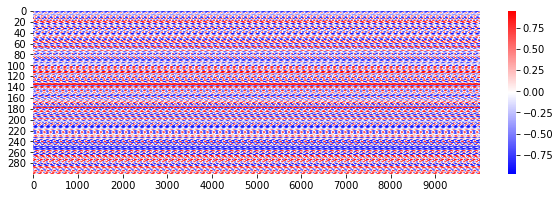

In [33]:
u = Y_train[:,:-1]
u  = np.vstack([np.ones((1,u.shape[1])), u])
X_new = np.tanh( Win @ u + W @ W2 @ np.tanh(W1 @ u))
Wout_new = Y_train[:,1:] @ X_new.T @ np.linalg.inv(X_new @ X_new.T + reg*np.eye(X_new.shape[0]))

plt.figure(figsize=(10,3))
sns.heatmap(X_new, yticklabels=20, xticklabels=1000, cmap='bwr')
print(Wout_new @ X_new - Y_train[:,1:] )

def model(y):
    u = np.atleast_2d(y)
    u = np.vstack((np.ones((1,u.shape[1])),u))
    return Wout_new @ np.tanh( Win @ u + W @ W2 @ np.tanh(W1 @ u))

def model_true(y):
    u = y
    return A @ u

def derivative(u):
    u = np.atleast_2d(u)
    u = np.vstack((np.ones((1,u.shape[1])),u))
    z1 = np.tanh(W1 @ u)
    z2 = np.tanh( Win @ u + W @ W2 @ np.tanh(W1 @ u))
    return Wout @ np.diag(1-z2**2) @ (W @ W2 @ np.diag(1-z1**2) @ W1 + Win)

In [34]:
err = model(Y_train[:,:-1]) - Y_train[:,1:]
np.average(np.square(err))

2.0691946643246363e-10

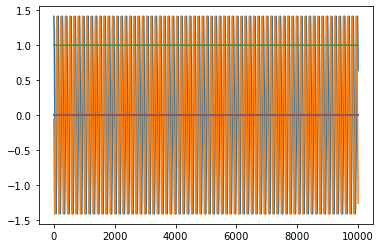

In [35]:
plt.plot(model(Y_train[:,:-1]).T)
plt.plot(model(Y_train[:,:-1]).T - Y_train[:,1:].T)

In [36]:
Js = []
for i in range(500):
    J = derivative(Y_train[:,i])
    print(J)
    Js.append(J)
Js = np.array(Js)
plt.figure(figsize=(20,3))
plt.plot(Js[:,0,0])

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 4)

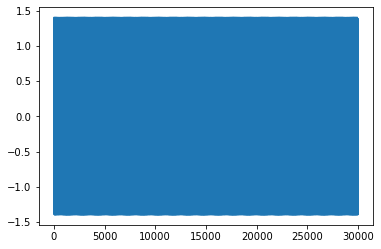

In [285]:
y = Y_train[:,-1:]
Ys = []
for i in range(10000):
    y = model(y)
    Ys.append(y)
Ys = np.array(Ys)
plt.plot(Ys.reshape(-1,1))
